In [52]:
# loading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
data = pd.read_csv('../data/processed_credit_card_transactions.csv')
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour_of_day
0,1.082874,0.176748,1.491675,2.666308,-0.654596,0.605123,-0.666474,0.328933,0.178518,0.463475,...,-0.018250,0.079978,0.044460,0.209370,-0.011420,0.056437,0.031140,0.0,0,17
1,-1.808226,1.390167,0.266081,0.518695,-0.209067,-0.165734,-0.218656,0.765490,-0.752461,0.048363,...,0.538654,-0.296581,0.110225,-0.321470,0.533114,-1.076942,-0.595472,0.0,0,17
2,1.213740,-0.387834,1.053145,-0.033415,-1.032340,0.038620,-0.836410,0.233345,0.908503,-0.205131,...,-0.118891,0.019575,0.081908,0.117328,0.994845,-0.039011,0.000699,0.0,0,17
3,-3.779876,-1.906684,0.849758,3.788975,2.166087,-1.270688,-0.657516,0.274214,-1.293508,0.764280,...,0.029546,0.295243,-0.024642,0.707250,0.435076,0.125716,-0.279834,0.0,0,17
4,-0.213737,0.726661,1.572802,-0.051265,-0.352745,-0.791121,0.457399,-0.020552,-0.392846,-0.382866,...,-0.165147,0.104641,0.644719,-0.876068,0.908815,0.079425,0.136631,0.0,0,17


In [4]:
# define features and target variable
X = data.drop('Class', axis=1)
y = data['Class']

In [5]:
# split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((135569, 30), (29050, 30), (29051, 30), (135569,), (29050,), (29051,))

#### RandomForestClassifier Model

In [ ]:
# modeling with Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
# base model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

# Train
rf.fit(X_train, y_train)

# Predict on validation set
y_pred = rf.predict(X_val)

# Evaluate
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[28984     0]
 [   20    46]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28984
           1       1.00      0.70      0.82        66

    accuracy                           1.00     29050
   macro avg       1.00      0.85      0.91     29050
weighted avg       1.00      1.00      1.00     29050



**Hyperparameter Tuning Model**

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score, fbeta_score

In [9]:
# using a sample of training data for hyperparameter tuning

X_tune, _, y_tune, _ = train_test_split(
    X_train,
    y_train,
    train_size=0.3,
    stratify=y_train,
    random_state=42
)
X_tune.shape, y_tune.shape

((40670, 30), (40670,))

In [28]:
# hyperparameter tuning with RandomizedSearchCV

rf = RandomForestClassifier(
    class_weight={0: 1, 1: 5},
    random_state=42,
    n_jobs=-1
)

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

recall_scorer = make_scorer(recall_score, pos_label=1)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,   
    scoring=recall_scorer,
    cv=3,
    random_state=42
)

random_search.fit(X_tune, y_tune)

# Best model
best_rf = random_search.best_estimator_
y_val_probs = best_rf.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_probs >= 0.3).astype(int) 

from sklearn.metrics import classification_report, confusion_matrix
print("Best Parameters:", random_search.best_params_)
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['Normal', 'Fraud']))

Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 20}
[[28968    16]
 [   14    52]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     28984
       Fraud       0.76      0.79      0.78        66

    accuracy                           1.00     29050
   macro avg       0.88      0.89      0.89     29050
weighted avg       1.00      1.00      1.00     29050



In [29]:
# train best model on full training data and evaluate on validation set

best_rf.fit(X_train, y_train)

y_val_probs = best_rf.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_probs >= 0.3).astype(int) 

print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['Normal', 'Fraud']))

[[28977     7]
 [   13    53]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     28984
       Fraud       0.88      0.80      0.84        66

    accuracy                           1.00     29050
   macro avg       0.94      0.90      0.92     29050
weighted avg       1.00      1.00      1.00     29050



In [30]:
# train the best model on the full training data and validation data and evaluate on test set
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

best_rf.fit(X_full_train, y_full_train)

y_test_probs = best_rf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_probs >= 0.3).astype(int) 

print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Fraud']))

[[29004     4]
 [   11    32]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     29008
       Fraud       0.89      0.74      0.81        43

    accuracy                           1.00     29051
   macro avg       0.94      0.87      0.90     29051
weighted avg       1.00      1.00      1.00     29051



#### XGBoost Classifier Model

In [33]:
from xgboost import XGBClassifier

In [34]:
# scale class weights
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 598.862831858407


In [ ]:
# define the base model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

# Train
xgb_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = xgb_model.predict(X_val)

# Evaluate
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['Normal', 'Fraud']))

[[28983     1]
 [   15    51]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     28984
       Fraud       0.98      0.77      0.86        66

    accuracy                           1.00     29050
   macro avg       0.99      0.89      0.93     29050
weighted avg       1.00      1.00      1.00     29050



**Hyperparameter Tuning Model**

In [ ]:
# hyperparameter tuning with RandomizedSearchCV

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    tree_method='hist' 
)

param_dist = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3]
}

f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=15,
    scoring=f2_scorer,
    cv=3,
    random_state=42,
    n_jobs=-1,
)

random_search_xgb.fit(X_train, y_train)

# Best model
best_xgb = random_search_xgb.best_estimator_
y_val_pred = best_xgb.predict(X_val)

print("Best Parameters:", random_search_xgb.best_params_)
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['Normal', 'Fraud']))

Best Parameters: {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
[[28981     3]
 [   13    53]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     28984
       Fraud       0.95      0.80      0.87        66

    accuracy                           1.00     29050
   macro avg       0.97      0.90      0.93     29050
weighted avg       1.00      1.00      1.00     29050



In [ ]:
# train the best model on the full training data and validation data and evaluate on test set
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

best_xgb.fit(X_full_train, y_full_train)

y_test_pred = best_xgb.predict(X_test)

print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Fraud']))

[[29006     2]
 [    9    34]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     29008
       Fraud       0.94      0.79      0.86        43

    accuracy                           1.00     29051
   macro avg       0.97      0.90      0.93     29051
weighted avg       1.00      1.00      1.00     29051



#### Model Selection Interpretation:
`XGBoost` was selected over `RandomForest` as it achieved `higher fraud recall` while maintaining very high precision, indicating better detection of fraudulent transactions with fewer false alerts. The model also demonstrated more consistent performance across validation and test datasets, making it suitable for deployment.

In [66]:
# save the best model
import joblib
joblib.dump(best_xgb, '../models/best_xgb_model.pkl')

['../models/best_xgb_model.pkl']

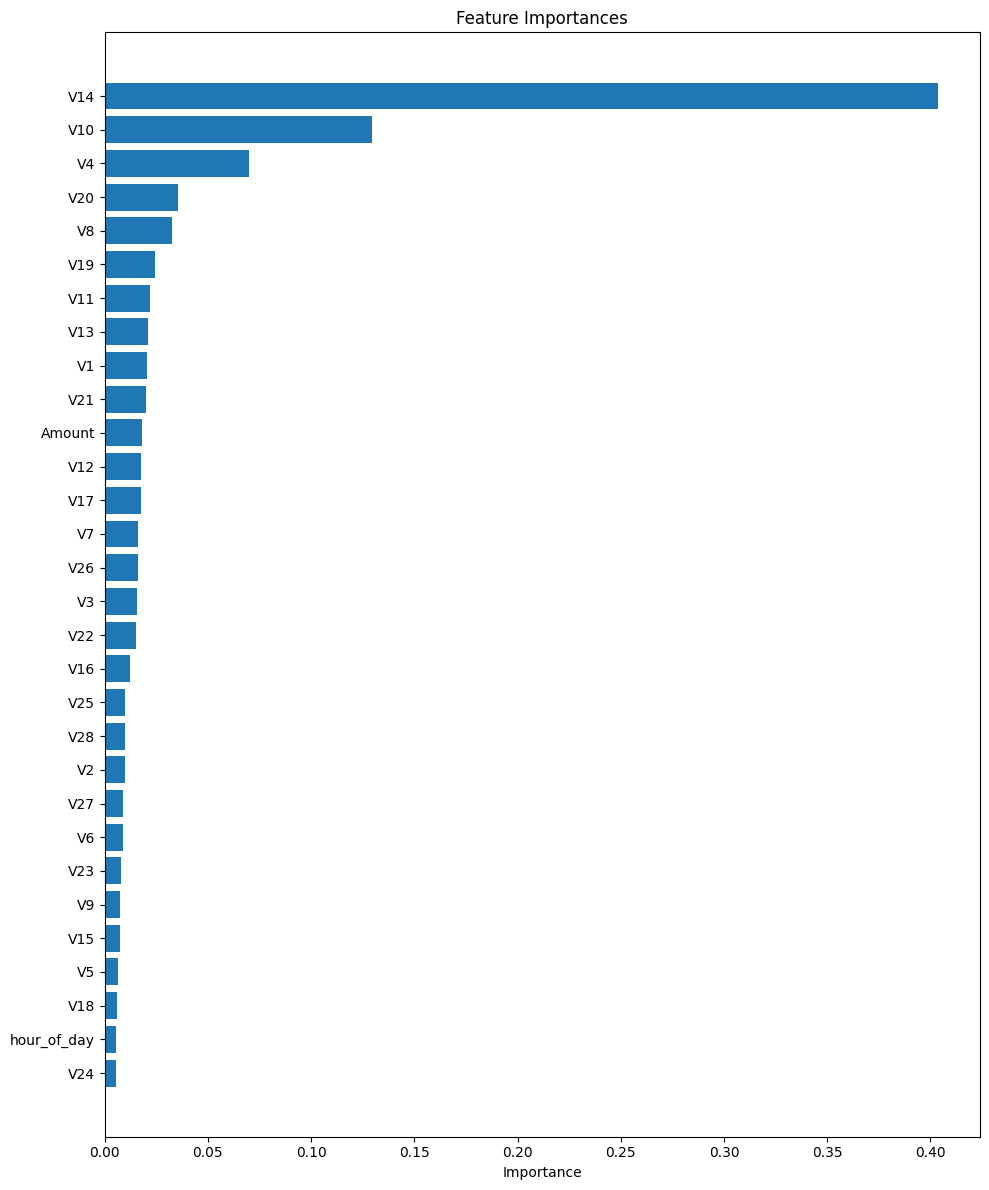

In [67]:
# feature importance plot
importances = best_xgb.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)
plt.figure(figsize=(10, 12))
plt.title("Feature Importances")
plt.barh(range(X.shape[1]), importances[indices])
plt.yticks(range(X.shape[1]), feature_names[indices])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

#### Model Explainability using SHAP

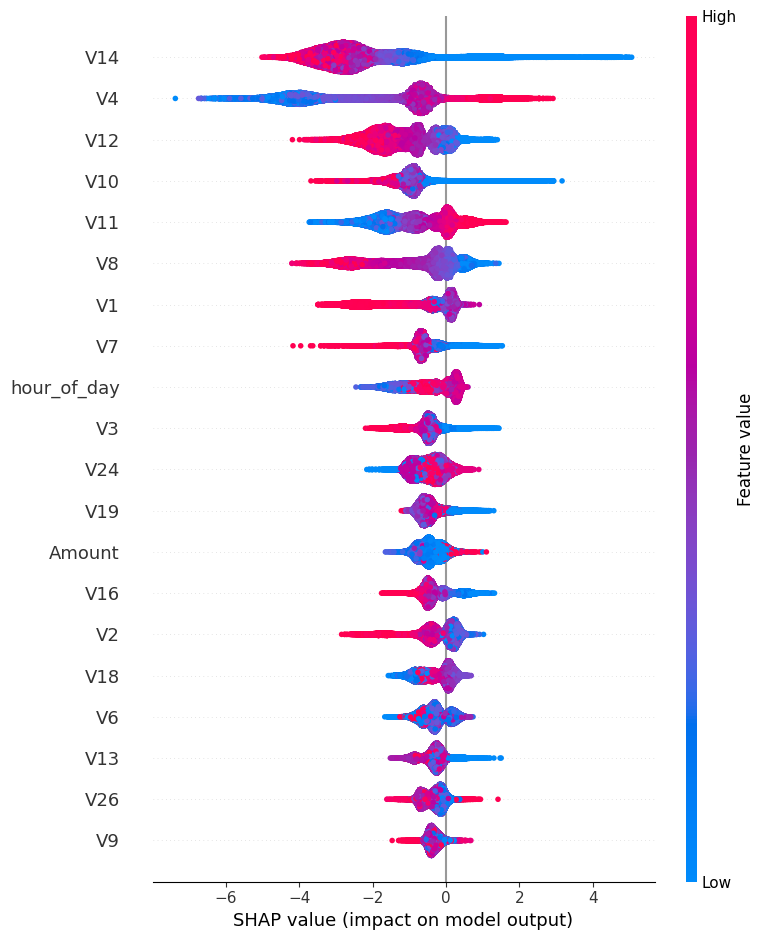

In [68]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(best_xgb)

# Calculate SHAP values
shap_values = explainer.shap_values(X_full_train)

# SHAP summary plot
shap.summary_plot(
    shap_values,
    X_full_train,
    plot_type="dot",
    show=True
)

##### Interpretation
SHAP analysis indicates that fraud predictions are primarily driven by behavioral features such as V14 and V4. Lower values of V14 and higher values of V4 consistently increase the likelihood of fraud, while transaction amount and time act as supporting contextual features. This demonstrates that the model captures meaningful transaction patterns rather than relying on simple threshold-based rules.


#### Exporting results

In [74]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29051 entries, 154840 to 152434
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   V1           29051 non-null  float64
 1   V2           29051 non-null  float64
 2   V3           29051 non-null  float64
 3   V4           29051 non-null  float64
 4   V5           29051 non-null  float64
 5   V6           29051 non-null  float64
 6   V7           29051 non-null  float64
 7   V8           29051 non-null  float64
 8   V9           29051 non-null  float64
 9   V10          29051 non-null  float64
 10  V11          29051 non-null  float64
 11  V12          29051 non-null  float64
 12  V13          29051 non-null  float64
 13  V14          29051 non-null  float64
 14  V15          29051 non-null  float64
 15  V16          29051 non-null  float64
 16  V17          29051 non-null  float64
 17  V18          29051 non-null  float64
 18  V19          29051 non-null  float64
 19  V20

In [ ]:
# exporing predictions 

y_test_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Combine into a DataFrame
predictions_df = pd.DataFrame({
    'Actual_Label': y_test,
    'Predicted_Label': y_test_pred,
    'Fraud_Probability': y_proba
})

predictions_df['Fraud_Probability'] = predictions_df['Fraud_Probability'].round(6)

# save to CSV
predictions_df.to_csv('../results/test_set_predictions.csv', index_label='Transaction_ID')

In [ ]:
# Export Summary Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1_Score': f1_score(y_test, y_test_pred),
    'Total_Transactions': len(y_test),
    'Total_Frauds_Actual': sum(y_test),
    'Total_Frauds_Predicted': sum(y_test_pred)
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('../results/fraud_summary_metrics.csv', index=False)

In [95]:
# Export SHAP Feature Impacts

# Calculate average absolute SHAP impact per feature
shap_summary = pd.DataFrame({
    'Feature': X_full_train.columns,
    'Average_SHAP_Impact': np.abs(shap_values).mean(axis=0)
}).sort_values(by='Average_SHAP_Impact', ascending=False)

shap_summary['Average_SHAP_Impact'] = shap_summary['Average_SHAP_Impact'].round(6)

shap_summary.to_csv('../results/shap_feature_impacts.csv', index=False)